<a href="https://colab.research.google.com/github/Mohammadreza-Rajabpoure/product-purchase-trend-in-wholesale-customers/blob/main/product_purchase_trend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install kneed

import necessory libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Untitled folder/wholesale+customers.zip')
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


change the dataframe to only have the customers from 'Channel 1'(hotel,cafe,restaurant) without considering the reigion

then drop the Reigion and Channel columns

In [ ]:
data = df.query('Channel==1').reset_index(drop=True)

fdata = data.drop(columns=['Region', 'Channel'])
fdata.head(5)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,13265,1196,4221,6404,507,1788
1,5963,3648,6192,425,1716,750
2,10253,1114,3821,397,964,412
3,5876,6157,2933,839,370,4478
4,7780,2495,9464,669,2518,501


In [ ]:
fdata.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000
mean,13475.560403,3451.724832,3962.137584,3748.251678,790.560403,1415.956376
std,13831.687502,4352.165571,3545.513391,5643.912500,1104.093673,3147.426922
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,4070.250000,1164.500000,1703.750000,830.000000,183.250000,379.000000
50%,9581.500000,2157.000000,2684.000000,2057.500000,385.500000,821.000000
75%,18274.750000,4029.500000,5076.750000,4558.750000,899.500000,1548.000000
max,112151.000000,43950.000000,21042.000000,60869.000000,6907.000000,47943.000000


scaled the data with standaredScaler and then normalize the data by PCA to reduce the daimentions but first we have to find the best component for PCA .
we use ''elbow method'' to find the best component

In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(fdata)

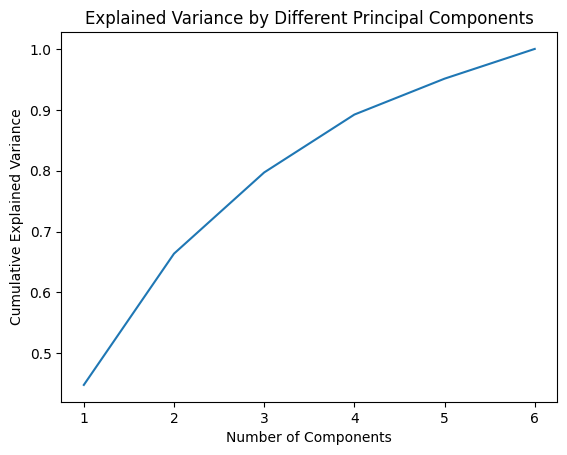




 best component: 3


In [ ]:
#find best pca with elbow method
pca = PCA().fit(scaled_data)

# Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Different Principal Components')
plt.show()

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance_ratio.cumsum()
optimal_num_components = len(cumulative_explained_variance[cumulative_explained_variance >= 0.95]) + 1

print('\n\n\n','best component:',optimal_num_components)

normalized the data with PCA

In [ ]:


npca = PCA(n_components=3)
pca_result = npca.fit_transform(scaled_data)




using KMeans to cluster the data but first we need to find the optimal number of cluster 'n_cluster' with help of ploting  elbow method and silhouette score

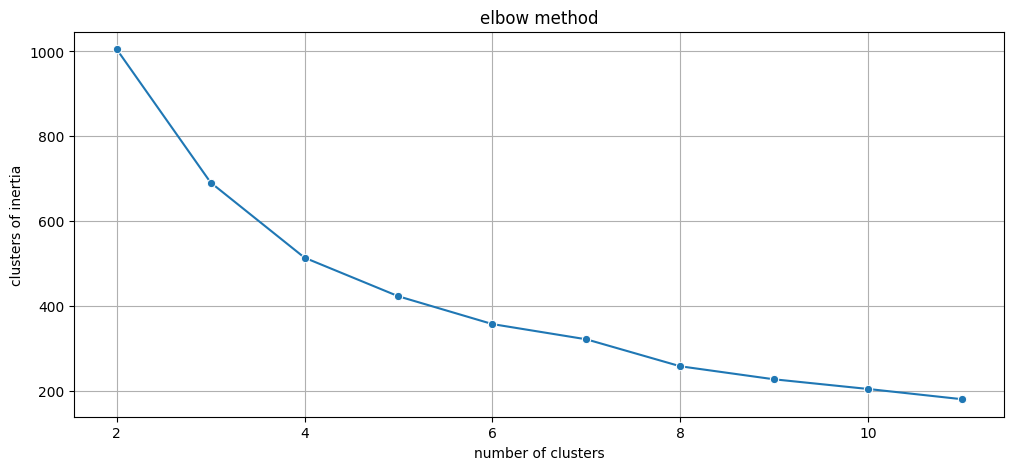

In [ ]:

clusters = np.arange(2,12)
clus_inertia = []
sil_score = []

for i in clusters:
  kms = KMeans(n_clusters=i, init='k-means++', random_state=42).fit(pca_result)
  clus_inertia.append(kms.inertia_)
  sil_avg = silhouette_score(pca_result, kms.labels_)
  sil_score.append(sil_avg)


fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(x=clusters, y=clus_inertia, marker='o', ax=ax)
ax.set_title('elbow method')
ax.set_xlabel('number of clusters')
ax.set_ylabel('clusters of inertia')
plt.grid()
plt.show()

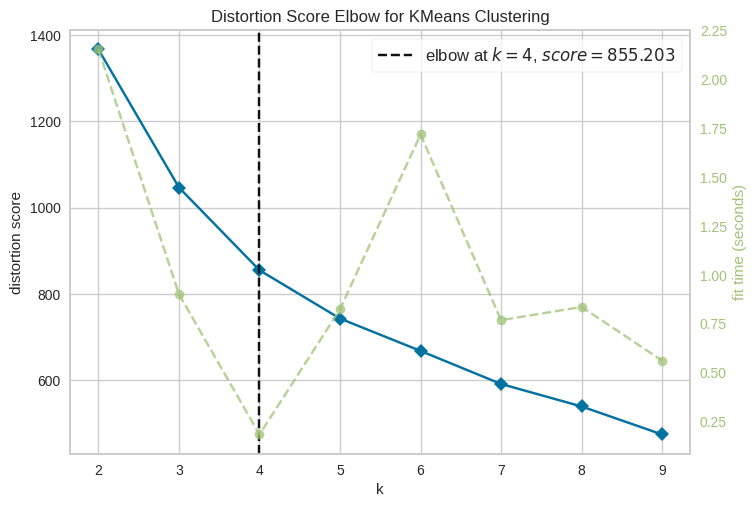

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
kmm = KMeans(random_state=42)
visualizer = KElbowVisualizer(kmm, k=(2,10))

visualizer.fit(scaled_data)        # Fit the data to the visualizer
visualizer.show()

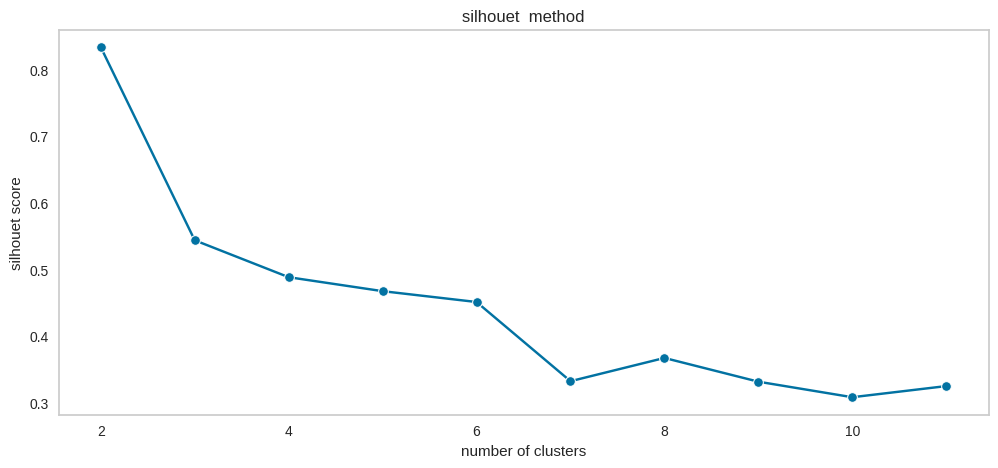

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(x=clusters, y=sil_score, marker='o', ax=ax)
ax.set_title('silhouet  method')
ax.set_xlabel('number of clusters')
ax.set_ylabel('silhouet score')
plt.grid()
plt.show()

In [ ]:
km = KMeans(n_clusters=4, random_state=42)
km.fit(pca_result)
cluster_labels = km.labels_


we should find outliers with DBSCAN

first we sould find the optimal 'esp' ad 'min_samples'

for that we use sklearn.NearestNeighbor to find epsilon and with ploting with elbow method find the epsilon
 in this case we shold asuum min_samples= 2*D where d is the dimention of dataset
and k=min_sample-1 for nearest neighbor

optimal epsilon 1.7189372151988946


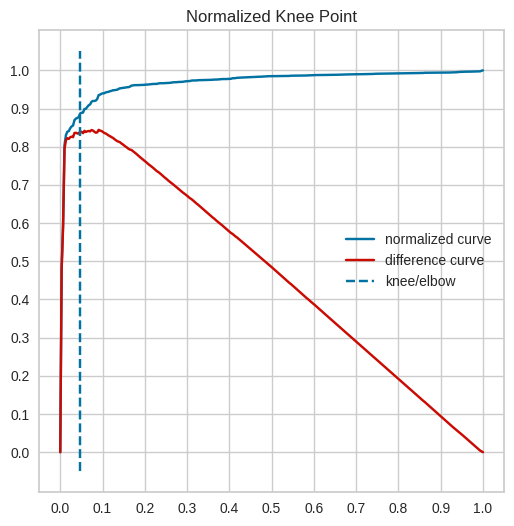

In [ ]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
from kneed import KneeLocator

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(pca_result)
distances, indices = neighbors_fit.kneighbors(pca_result)
distance_desc = sorted(distances[:,5-1], reverse=True)

#ploting

kneedle = KneeLocator(range(1,len(distance_desc)+1),  #x values
                      distance_desc, # y values
                      S=1.0, #parameter suggested from paper
                      curve="convex", #parameter from figure
                      direction="decreasing") #parameter from figure

kneedle.plot_knee_normalized()
print('optimal epsilon',kneedle.knee_y)

now test wich wether the min_sample is optipal or not with silhouette score

In [ ]:
from sklearn.cluster import DBSCAN
from itertools import product

eps_values = np.arange(1.6,3,0.1)
min_samples = np.arange(6,14)
dbscan_params =  list (product(eps_values, min_samples))

num_of_clusters =[]
sil_score2 = []

for i in dbscan_params:
  DBS = DBSCAN(eps=i[0], min_samples=i[1]).fit(pca_result)
  num_of_clusters.append(len(np.unique(DBS.labels_)))
  sil_score2.append(silhouette_score(pca_result, DBS.labels_))


check if the min_sample is optimal

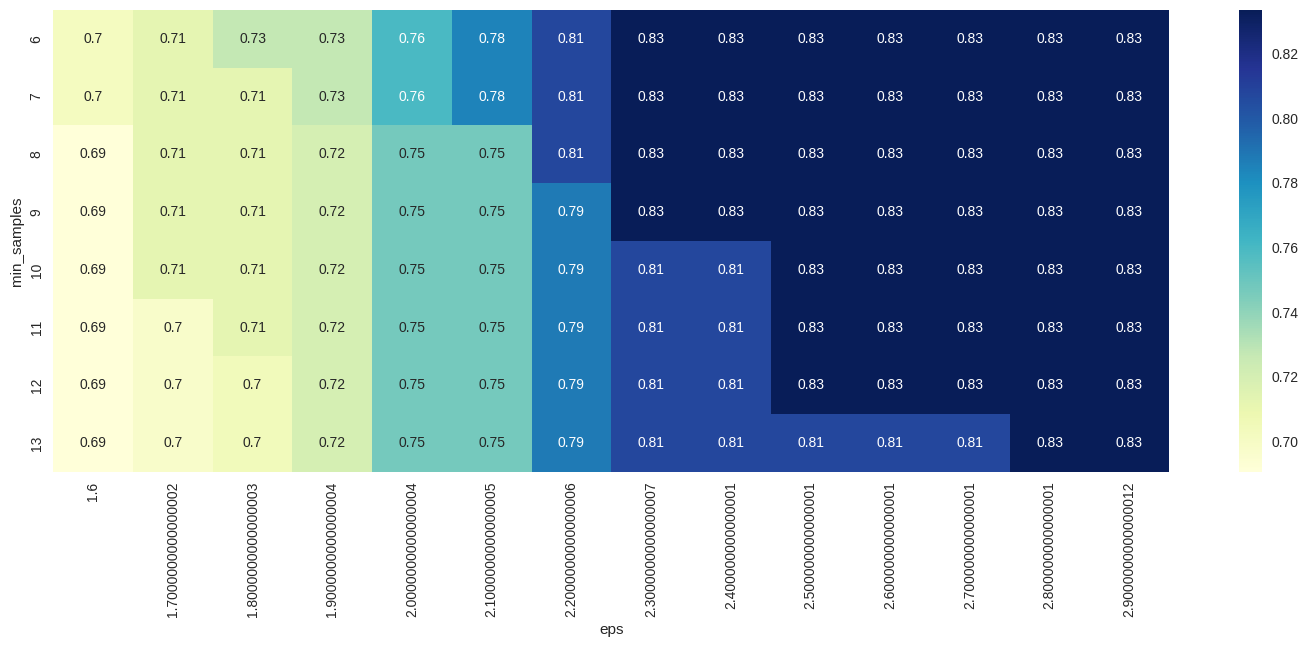

In [ ]:

tmp =pd.DataFrame.from_records(dbscan_params, columns=['eps', 'min_samples'])
tmp['sil_score'] = sil_score2

pivot_1 = pd.pivot_table(tmp, values='sil_score', index = 'min_samples', columns='eps')

fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1, annot=True, annot_kws={"size":10}, cmap="YlGnBu" , ax=ax)
plt.show()

optimal params  min_samples=6 and eps=1.7189372151988946

In [ ]:
DBS_clustering = DBSCAN(eps=1.7189372151988946, min_samples=6).fit(pca_result)

DBS_clustered = pd.DataFrame(pca_result.copy())
DBS_clustered.loc[:,'Cluster'] = DBS_clustering.labels_

DBS_sizes = DBS_clustered.groupby('Cluster').size().to_frame()
DBS_sizes

,0
Cluster,
-1,10
0,288


seperate outliers from

In [ ]:
outliers = DBS_clustered[DBS_clustered['Cluster']==-1]
outliers = outliers.drop(columns='Cluster')

outliers


,0,1,2
30,4.990987,2.871115,-0.010035
43,1.735674,-3.110096,0.748009
105,9.940615,0.075743,-4.598089
106,2.201270,5.282106,-0.733467
107,16.477906,-4.532667,7.081145
128,3.349419,4.856199,-0.304308
170,4.319004,0.678642,1.789207
211,7.788911,-3.872315,0.320709
252,4.123004,0.786749,1.618710
282,2.399585,5.349033,-1.062994


In [ ]:
#select outliers from pca result

pca_outliers = pca_result[[30,43,105,106,107,128,170,211,252,282]]


analyzing pca loadings

In [ ]:
pca_components = npca.components_

# Create a DataFrame for better visualization and analysis
pca_loadings_df = pd.DataFrame(pca_components, columns=fdata.columns, index=[f'PC{i+1}' for i in range(npca.n_components)])

# Display the loadings
pca_loadings_df

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
PC1,0.285955,0.515478,0.484614,0.370126,0.246992,0.468682
PC2,-0.377248,0.015584,0.366385,-0.438808,0.703271,-0.189895
PC3,-0.826165,0.275508,-0.095726,0.045976,-0.262199,0.401898


pc1 >>> milk, gocery , detergent_paper

pc2 >> f
rozen , fresh , delicassen

pc3 >> delicassen








> Add blockquote



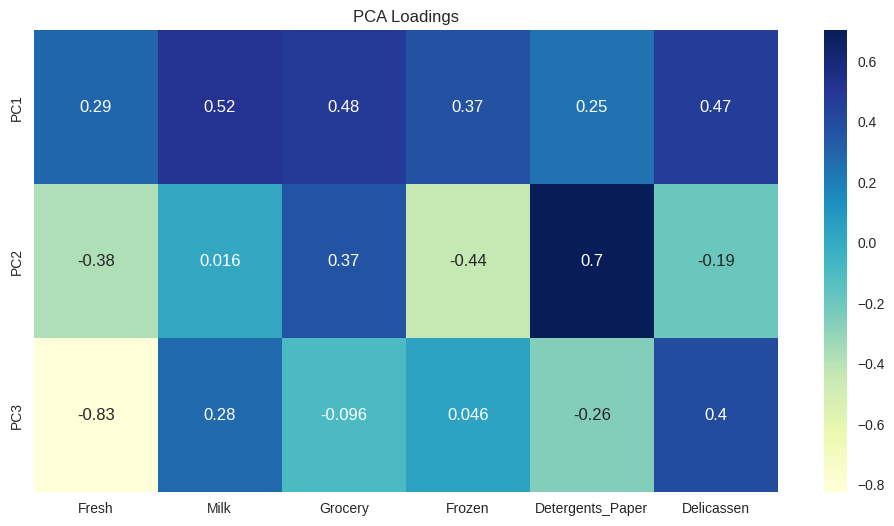

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(pca_loadings_df, cmap="YlGnBu", annot=True)
plt.title('PCA Loadings')
plt.show()

In [ ]:
# Inverse transform the cluster centers
original_space_centroids = scaler.inverse_transform(npca.inverse_transform(km.cluster_centers_))

# Create a DataFrame for the inverse transformed cluster centers
centroids_df = pd.DataFrame(original_space_centroids, columns=fdata.columns)

# Display the centroids
centroids_df

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,35039.505251,4742.453399,5163.556346,8165.341440,716.163561,2337.797136
1,62300.502651,29920.338959,19603.811735,34634.163907,1472.514294,21044.840620
2,8356.087184,6839.178592,9649.665847,990.914299,3069.258729,2069.702074
3,9460.933611,2336.259304,2666.351024,2897.418163,453.659316,874.240136


In [ ]:
# Calculate the mean of the original data
original_means = fdata.mean(axis=0)
print(original_means)
centroids_comparison_df = pd.concat([centroids_df, pd.DataFrame([original_means])], ignore_index=True)

centroids_comparison_df

Fresh               13475.560403
Milk                 3451.724832
Grocery              3962.137584
Frozen               3748.251678
Detergents_Paper      790.560403
Delicassen           1415.956376
dtype: float64


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,35039.505251,4742.453399,5163.556346,8165.341440,716.163561,2337.797136
1,62300.502651,29920.338959,19603.811735,34634.163907,1472.514294,21044.840620
2,8356.087184,6839.178592,9649.665847,990.914299,3069.258729,2069.702074
3,9460.933611,2336.259304,2666.351024,2897.418163,453.659316,874.240136
4,13475.560403,3451.724832,3962.137584,3748.251678,790.560403,1415.956376


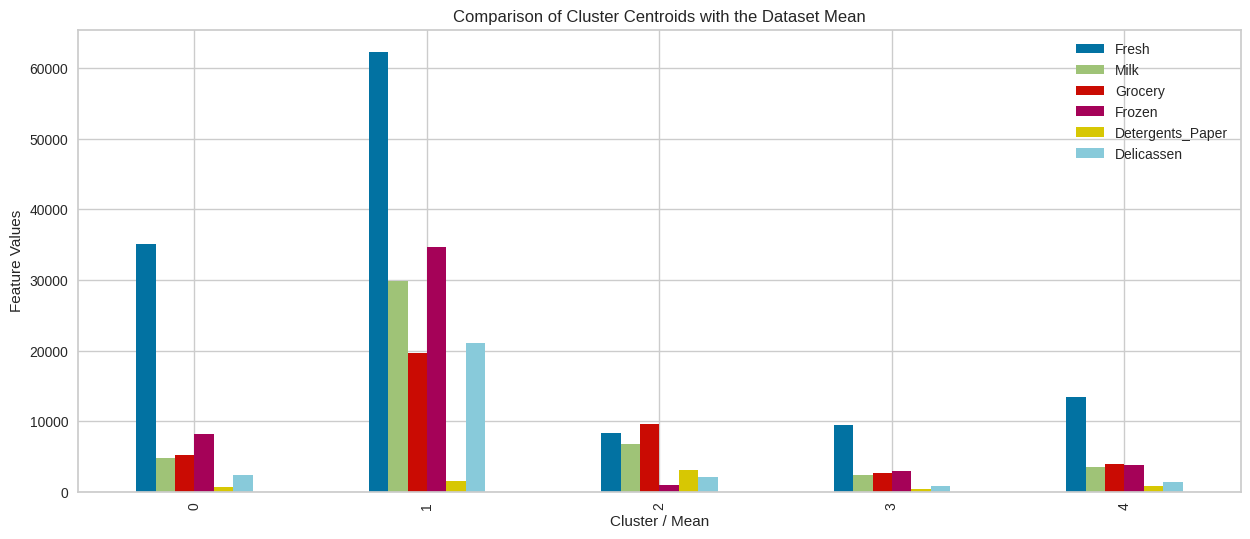

In [ ]:
centroids_comparison_df.plot(kind='bar', figsize=(15, 6))
plt.title('Comparison of Cluster Centroids with the Dataset Mean')
plt.xlabel('Cluster / Mean')
plt.ylabel('Feature Values')
plt.show()

In [ ]:
# Extract the absolute values of the loadings
pca_loadings_analysis = pd.DataFrame(
    np.abs(npca.components_),
    columns=fdata.columns,
    index=[f'PC{i+1}' for i in range(npca.n_components)]
)
print(pca_loadings_analysis)
# Identify the top contributing features for each principal component
top_features_per_pc = pca_loadings_analysis.apply(lambda s: s.nlargest(2).index.tolist(), axis=1)

print(top_features_per_pc)

        Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicassen
PC1  0.285955  0.515478  0.484614  0.370126          0.246992    0.468682
PC2  0.377248  0.015584  0.366385  0.438808          0.703271    0.189895
PC3  0.826165  0.275508  0.095726  0.045976          0.262199    0.401898
PC1               [Milk, Grocery]
PC2    [Detergents_Paper, Frozen]
PC3           [Fresh, Delicassen]
dtype: object


In [ ]:

# Function to get top features and their loadings
def get_top_features_loadings(pca_loadings, n_features):
    top_features = {}
    for i in range(pca_loadings.shape[0]):
        top_indices = np.argsort(np.abs(pca_loadings[i]))[-n_features:]
        top_features[f'PC{i+1}'] = {fdata.columns[j]: pca_loadings[i][j] for j in top_indices}
    return top_features

# Get and display the top features and their loadings
top_features_loadings = get_top_features_loadings(npca.components_, 2)
top_features_loadings_df = pd.DataFrame(top_features_loadings).T

top_features_loadings_df

,Grocery,Milk,Frozen,Detergents_Paper,Delicassen,Fresh
PC1,0.484614,0.515478,NaN,NaN,NaN,NaN
PC2,NaN,NaN,-0.438808,0.703271,NaN,NaN
PC3,NaN,NaN,NaN,NaN,0.401898,-0.826165


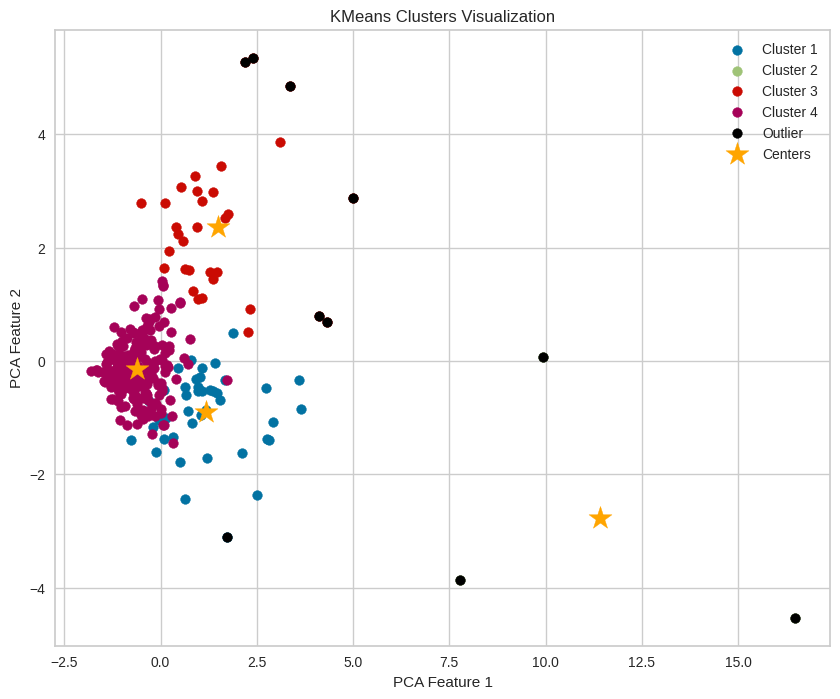

In [ ]:
plt.figure(figsize=(10, 8))

# Scatter plot of the data points, colored by their cluster label
for i in range(4):
    # Select only data points with the cluster label equal to 'i'
    ds = pca_result[cluster_labels == i]
    out = pca_outliers
    # Plot these data points
    plt.scatter(ds[:, 0], ds[:, 1], label=f'Cluster {i+1}')

#plot outliers
out = pca_outliers
plt.scatter(out[:, 0], out[:, 1], label='Outlier',c='black')
# Marking the cluster centers
centers = km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], s=300, c='orange', label='Centers', marker='*')


plt.title('KMeans Clusters Visualization')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.legend()
plt.show()